https://www.kaggle.com/competitions/vehicle/overview

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Import library
import os
import shutil
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from collections import Counter

In [3]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [4]:
import itertools
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, optimizers, regularizers

In [5]:
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
path_train_orig='vehicle/train/trainset/'
path_test='vehicle/test/'

In [8]:
pd.DataFrame(os.listdir(path_train_orig)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Ambulance,Barge,Bicycle,Boat,Bus,Car,Cart,Caterpillar,Helicopter,Limousine,Motorcycle,Segway,Snowmobile,Tank,Taxi,Truck,Van


In [9]:
# make dataset
data=[]
for categories in os.listdir(path_train_orig):
    for img in os.listdir(path_train_orig+categories):
        data.append((path_train_orig+categories+'/'+img, categories, img))
                    
df_train=pd.DataFrame(data, columns=['data_path', 'class', 'imagen' ])
df_train.head()

,data_path,class,imagen
0,vehicle/train/trainset/Ambulance/000040_09.jpg,Ambulance,000040_09.jpg
1,vehicle/train/trainset/Ambulance/000050_10.jpg,Ambulance,000050_10.jpg
2,vehicle/train/trainset/Ambulance/000052_03.jpg,Ambulance,000052_03.jpg
3,vehicle/train/trainset/Ambulance/000057_04.jpg,Ambulance,000057_04.jpg
4,vehicle/train/trainset/Ambulance/000067_14.jpg,Ambulance,000067_14.jpg


In [10]:
# value count of class
df_train['class'].value_counts()

Boat           8695
Car            6781
Motorcycle     2986
Bus            2133
Truck          2033
Bicycle        1618
Van            1111
Taxi            748
Helicopter      668
Caterpillar     331
Tank            206
Barge           202
Segway          153
Ambulance       132
Snowmobile      123
Limousine        74
Cart             51
Name: class, dtype: int64

In [11]:
categories = df_train['class'].unique()
categories 

array(['Ambulance', 'Barge', 'Bicycle', 'Boat', 'Bus', 'Car', 'Cart',
       'Caterpillar', 'Helicopter', 'Limousine', 'Motorcycle', 'Segway',
       'Snowmobile', 'Tank', 'Taxi', 'Truck', 'Van'], dtype=object)

# Convolutional Neural Network (CNN)

In [12]:
# epochs
epochs_val = 15

# batch_size
batch_size_val = 32

# target_size
#224
target_size_val=(128,128)

# input_shape
input_shape_val = (target_size_val[0],target_size_val[1], 3)

## Data Generators

In [13]:
# Datagen and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=None,
    validation_split= 0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Train / Validation - Data Generator
train_generator = train_datagen.flow_from_directory(path_train_orig,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical',
                                 subset = "training")

val_generator = train_datagen.flow_from_directory(path_train_orig,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical',
                                 subset = "validation")

# Test 
test_generator = test_datagen.flow_from_directory(path_test,
                                 target_size=target_size_val,
                                 shuffle = False)

Found 19641 images belonging to 17 classes.
Found 8404 images belonging to 17 classes.
Found 7958 images belonging to 1 classes.


In [15]:
# class_weight - Unbalanced Data

counter = Counter(train_generator.classes)                          
class_weights = dict(zip(list(counter.keys()),
                 class_weight.compute_class_weight('balanced', list(counter.keys()),train_generator.classes)))
class_weights

{0: 12.42314990512334,
 1: 8.136288318144159,
 2: 1.0197289860339547,
 3: 0.1898066274316528,
 4: 0.7733286085518545,
 5: 0.24338591556277028,
 6: 32.09313725490196,
 7: 4.979969574036511,
 8: 2.4687028657616894,
 9: 22.218325791855204,
 10: 0.5525360789940079,
 11: 10.697712418300654,
 12: 13.279918864097363,
 13: 7.967951318458418,
 14: 2.2048720251459364,
 15: 0.8113433575677462,
 16: 1.4850294873733556}

In [16]:
train_generator.classes

array([ 0,  0,  0, ..., 16, 16, 16], dtype=int32)

In [17]:
train_generator.class_indices

{'Ambulance': 0,
 'Barge': 1,
 'Bicycle': 2,
 'Boat': 3,
 'Bus': 4,
 'Car': 5,
 'Cart': 6,
 'Caterpillar': 7,
 'Helicopter': 8,
 'Limousine': 9,
 'Motorcycle': 10,
 'Segway': 11,
 'Snowmobile': 12,
 'Tank': 13,
 'Taxi': 14,
 'Truck': 15,
 'Van': 16}

In [18]:
train_generator_dict={y: x for x, y in train_generator.class_indices.items()}
train_generator_dict

{0: 'Ambulance',
 1: 'Barge',
 2: 'Bicycle',
 3: 'Boat',
 4: 'Bus',
 5: 'Car',
 6: 'Cart',
 7: 'Caterpillar',
 8: 'Helicopter',
 9: 'Limousine',
 10: 'Motorcycle',
 11: 'Segway',
 12: 'Snowmobile',
 13: 'Tank',
 14: 'Taxi',
 15: 'Truck',
 16: 'Van'}

Found 28045 images belonging to 17 classes.


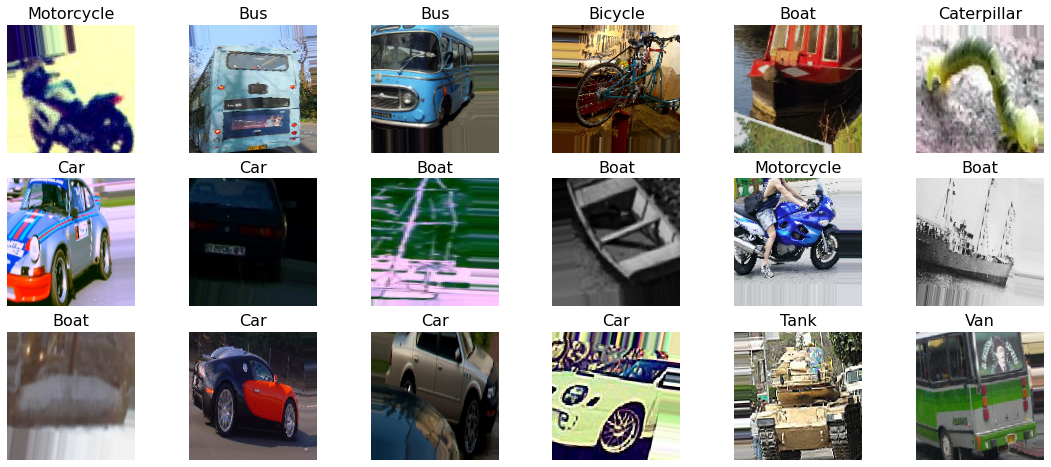

In [135]:
# plot image of train_generator_image

train_datagen_image = ImageDataGenerator(rescale=1./255)

train_generator_image = train_datagen.flow_from_directory(path_train_orig,
                                 target_size=target_size_val,
                                 batch_size=200)
plt.figure(figsize = (19, 8))
image_train_gen, cl = next(train_generator_image) # len(next(train_generator)) = batch_size
for i in range(18):
    ax=plt.subplot(3,6,i+1)
    im = image_train_gen[i]
    plt.imshow(im)
    plt.title(train_generator_dict[np.where(cl[i]==1)[0][0]],fontsize=16)
    plt.axis('off')